In [1]:
import torch
torch.manual_seed(0)

import torchzero as tz
from visualbench import FunctionDescent, test_functions

# Momentum
### Heavy-ball momentum
Momentum can be used to accelerate gradient descent and possibly other algorithms. The idea is to add "intertia" to gradient descent by using the Polyak's momentum formula:
$$
x_{t+1} = x_t - \eta \nabla f(x_t) + \beta (x_t - x_{t-1})
$$
Here $\eta$ is the step size and $\beta$ is the momentum hyperparameter, often set to 0.9 or 0.95.

The formula can be also rewritten in the following way:
$$
v \rightarrow  \beta v + \nabla f(x) \\\\

x \rightarrow x - \eta v
$$
Here $v$ is the velocity which is used to update the parameters.

Let's run it on rosenbrock's function
$$
f(x,y) = (1 - x)^2 + 100 * (y - x^2)^2
$$

Standard gradient descent requires about 10,000 steps to reach the value of 1e-4, whereas HeavyBall method requires only 2,000 steps.

Reference: *[Polyak, Boris T. "Some methods of speeding up the convergence of iteration methods." Ussr computational mathematics and mathematical physics 4.5 (1964): 1-17.](https://papers.baulab.info/papers/also/Polyak-1964.pdf)*

finished in 2.0s., reached loss = 0.000154                                      


<Axes: >

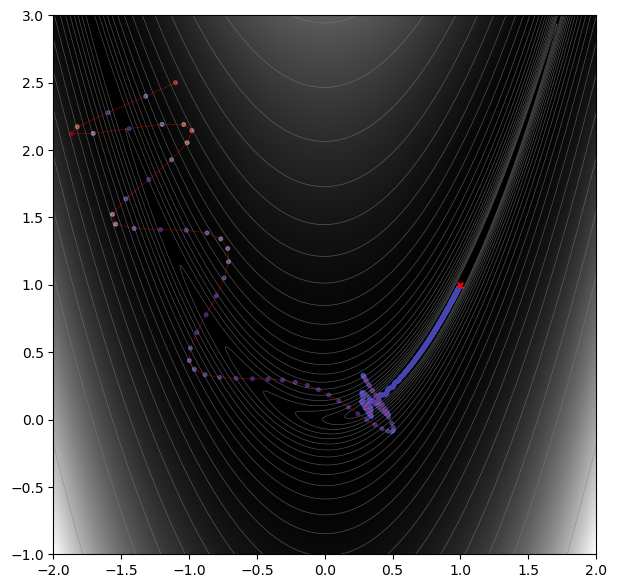

In [21]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.HeavyBall(0.95), tz.m.LR(2e-4))
func.run(optimizer, max_steps=2000)
func.plot(log_contour=True)

### Nesterov's momentum

Heavy ball momentum can have a lot of oscillation as seen on rosenbrock function, and Nesterov's momentum formula[2] tends to reduce those osciallations, often leading to faster convergence.

$$
v \rightarrow \beta (v + \nabla f(x)) \\\\

x \rightarrow x - \eta (\nabla f(x) + v)
$$

Reference: *Nesterov, Yurii. "A method for solving the convex programming problem with convergence rate O (1/k2)." Dokl akad nauk Sssr. Vol. 269. 1983.*

finished in 0.9s., reached loss = 6.89e-09                                      


<Axes: >

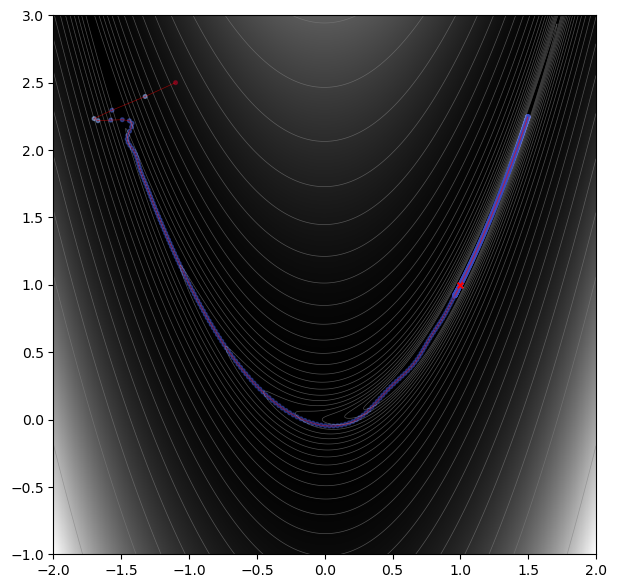

In [24]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.NAG(0.99), tz.m.LR(2e-4))
func.run(optimizer, max_steps=1000)
func.plot(log_contour=True)

### Exponential moving average
Many optimizers, for example Adam, use the exponential moving average of gradients in place of momentum. The formula is similar to heavy ball formula, but with an extra $(1 - \beta)$ term:
$$
v \rightarrow \beta v + (1 - \beta) \nabla f(x) \\\\

x \rightarrow x - \eta v
$$

finished in 1.9s., reached loss = 0.000117                                      


<Axes: >

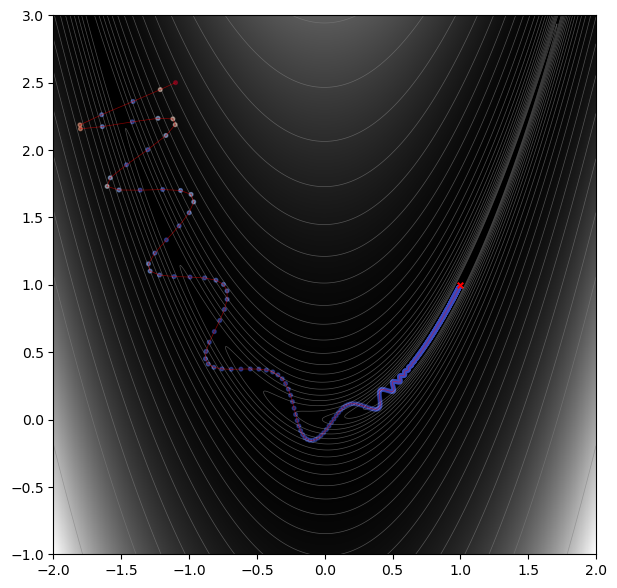

In [28]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.EMA(0.95), tz.m.LR(4e-3))
func.run(optimizer, max_steps=2000)
func.plot(log_contour=True)

### Cautious momentum
The idea of cautious updates is that when signs of gradient and momentum for a weight differ, update for that weight is zeroed. Cautioning can be applied to any momentum-based optimizer.

Reference: *[Liang, Kaizhao, et al. "Cautious optimizers: Improving training with one line of code." arXiv preprint arXiv:2411.16085 (2024).](https://arxiv.org/abs/2411.16085)*

finished in 3.1s., reached loss = 1e-05                                      


<Axes: >

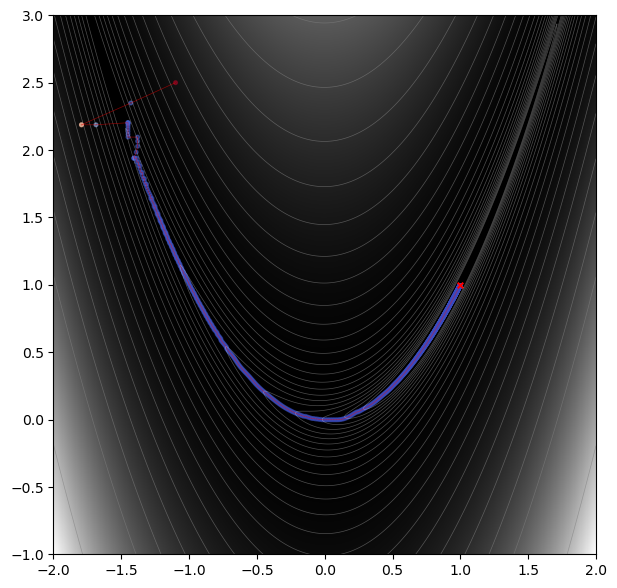

In [52]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(func.parameters(), tz.m.HeavyBall(0.95), tz.m.Cautious(), tz.m.LR(3e-4))
func.run(optimizer, max_steps=2000)
func.plot(log_contour=True)

### Matrix momentum
Matrix momentum is a momentum algorithm that uses inverse hessian as the preconditioner while only requiring a hessian-vector product with previous update on each step.

The method is based on the observation that at late times, with momentum, dynamics of the training is similar to dynamics without momentum, but with a scaled learning rate:
$$
\mathrm{u_0} = \frac{\mathrm{u_0}}{1 - \beta}
$$
here $\mathrm{u_0}$ is the effective learning rate, $\mathrm{u_0}$ is the actual learning rate and $\beta$ is the momentum hyperparameter. In Newton's method learning rate is replaced by inverse of the hessian matrix:
$$
w \rightarrow w - H^{-1} g
$$
Since newton's method is very fast, we would like effective learning rate to be $H^{-1}$. So if we replace effective learning rate $u_{eff}$ with inverse hessian $H^{-1}$ in the 1st formula, we get:
$$
H^{-1} = \mathrm{u_0}(I - \beta)^{-1}
$$
To get a nice formula, multiply both sides by $(I - \beta)$, then multiply both sides by $H$:
$$
H^{-1} (I - \beta) = \mathrm{u_0} (I - \beta)^{-1} (I - \beta) \\\\
H^{-1} (I - \beta) = \mathrm{u_0} I \\\\
H H^{-1}  (I - \beta) = H (\mathrm{u_0} I) \\\\
I (I - \beta) = \mathrm{u_0} H \\\\
I - \beta = \mathrm{u_0} H \\\\
\beta = I - \mathrm{u_0} H
$$
So we have a formula for the momentum parameter $\beta$, which now becomes a matrix, such that the effective learning rate is $H^{-1}$. If we put this into the Polyak's momentum formula:
$$
x_{t+1} = x_t - \eta \nabla f(x_t) + \beta (x_t - x_{t-1})
$$
We replace $\beta$ with our $I - \mathrm{u_0} H$ and we obtain the Matrix momentum update formula:
$$
x_{t+1} = x_t - \eta \nabla f(x_t) + (I - \mathrm{u_0} H) (x_t - x_{t-1})
$$
Or it can be written as
$$
s_t = x_t - x_{t-1} \\\\
x_{t+1} = x_t - \eta \nabla f(x_t) + s_t - \mathrm{u_0} H s_t
$$
So this doesn't need the hessian or the inverse, all it requires is a hessian-vector product $H s_t$.

MatrixMomentum requires tuning the ``mu`` hyperparameter. Authors suggest that ``mu`` should be less than $1/\lambda_{max}$, where $\lambda_{max}$ is the largest hessian eigenvalue. I have included an experimental heuristic for estimating ``mu`` as $\frac{||s||_2}{||y||_2}$, where $s_t = x_t - x_{t-1}$ and $y_t = \nabla f(x_t) - \nabla f(x_{t-1})$, which can be enabled by setting ``adaptive=True``, for stochastic optimization ``adapt_freq`` should also be set.

 Since learning rate is part of the update rule, ``tz.m.LR`` should not be used.

Reference: *[Orr, Genevieve, and Todd Leen. "Using curvature information for fast stochastic search." Advances in neural information processing systems 9 (1996).](https://proceedings.neurips.cc/paper_files/paper/1996/file/c4851e8e264415c4094e4e85b0baa7cc-Paper.pdf)*

finished in 0.2s., reached loss = 1.56e-06                                      


<Axes: >

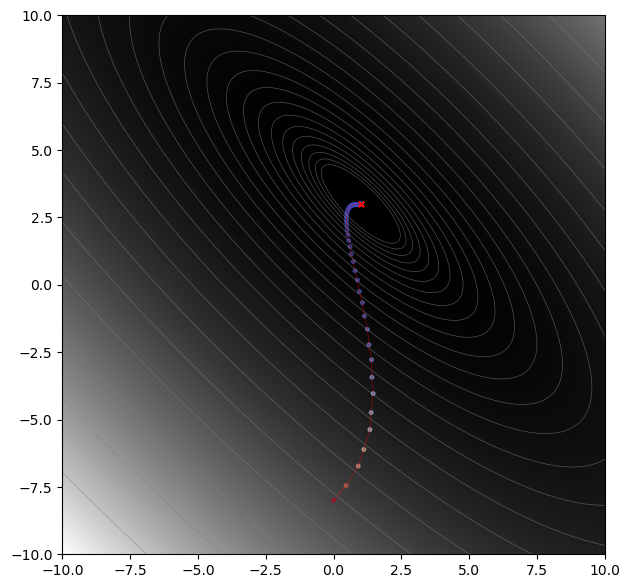

In [15]:
func = FunctionDescent('booth')
optimizer = tz.Modular(func.parameters(), tz.m.MatrixMomentum(lr=1e-2, mu=0.1))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True)

### Nested momentum

As an experiment it is possible to take the output of a momentum module and pass it to another momentum module.

finished in 3.2s., reached loss = 0.0011                                      


<Axes: >

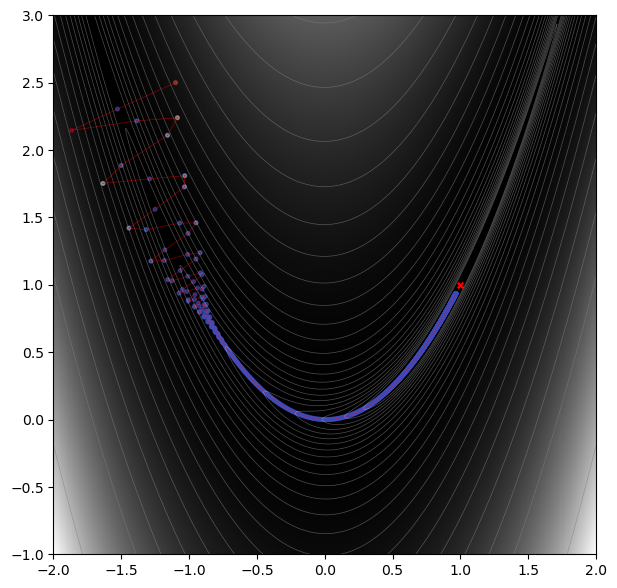

In [25]:
func = FunctionDescent('rosen')
optimizer = tz.Modular(
    func.parameters(), 
    tz.m.NAG(0.5),
    tz.m.NAG(0.5),
    tz.m.NAG(0.5),
    tz.m.NAG(0.5),
    tz.m.NAG(0.5),
    tz.m.LR(1e-4),
)
func.run(optimizer, max_steps=2000)
func.plot(log_contour=True)